# Q4 Mark b

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import shapely.geometry as shapgeo
from copy import deepcopy
import os

## Preliminary Functions

In [ ]:
def read_files(ddir):
    images = dict()
    ACCEPTED_FORMAT = ['jpg', 'png']
    for d in sorted(os.listdir(ddir)):
        if d.split('.')[1].lower() in ACCEPTED_FORMAT:
            fname = d.split('.')[0]
            print(f'reading {os.path.join(ddir, d)}...')
            images[fname] = cv2.imread(os.path.join(ddir, d), cv2.IMREAD_UNCHANGED)
            images[fname] = cv2.cvtColor(images[fname], cv2.COLOR_BGR2RGB)
    return images

def display_all(imgs, subs=(10,10), fgsz=(15,18), use_gray=False):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=fgsz)
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            axs[i, j].imshow(list(imgs.values())[k], 'gray' if use_gray else None)
            axs[i, j].set_title(list(imgs.keys())[k])
            axs[i, j].axis('off')
            k+=1
            
def display_all_with(imgs, cc, subs=(10,10), fgsz=(15,18), use_gray=True):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=fgsz)
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            axs[i, j].imshow(list(imgs.values())[k][:,:,cc], cmap='gray' if use_gray else None)
            axs[i, j].set_title(list(imgs.keys())[k])
            axs[i, j].axis('off')
            k+=1
            
def save_plots(imgs, suptitle, savedir, subs=(10,10), fgsz=(15,18), use_gray=False):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=fgsz)
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            axs[i, j].imshow(list(imgs.values())[k], 'gray' if use_gray else None)
            axs[i, j].set_title(list(imgs.keys())[k])
            axs[i, j].axis('off')
            k+=1
    fig.suptitle(suptitle)
    fig.savefig(savedir)
    print(f'Figure is successfully saved at {savedir}')

def adjust_gamma(image, gamma=1.0):
    table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image, table)

## Draw Functions

In [3]:
def draw_od_line(imgs, roi_line, color):
    odlines = {}
    for img in imgs:
        odlines[img] = cv2.ellipse(imgs[img], 
                                   roi_line[img], 
                                   color, 
                                   3, 
                                   cv2.LINE_AA)
    return odlines

def draw_oc_line(imgs, roi_line, color):
    drawn_oc = {}
    
    for img in imgs:
        drawn_oc[img] = cv2.circle(imgs[img],roi_line[img][0],roi_line[img][1],color, 3)
    return drawn_oc

## Main

In [4]:
# home = r'/home/tsdhrm/Pictures/thesis/Dataset/100DataAll'
# IDEAL = r'/home/tsdhrm/Pictures/thesis/Dataset/100DataAll/Positive59.png'
home = r'/Users/teguhsatya/Dev/segeralulus/Dataset/100DataAll'
IDEAL = r'/Users/teguhsatya/Dev/segeralulus/Dataset/100DataAll/Positive59.png'

In [5]:
images = read_files(home)
ideal = cv2.imread(IDEAL)
ideal = cv2.cvtColor(ideal, cv2.COLOR_BGR2RGB)

reading /Users/teguhsatya/Dev/segeralulus/Dataset/100DataAll/Negative1.jpg...
reading /Users/teguhsatya/Dev/segeralulus/Dataset/100DataAll/Negative10.jpg...
reading /Users/teguhsatya/Dev/segeralulus/Dataset/100DataAll/Negative11.jpg...
reading /Users/teguhsatya/Dev/segeralulus/Dataset/100DataAll/Negative12.jpg...
reading /Users/teguhsatya/Dev/segeralulus/Dataset/100DataAll/Negative13.jpg...
reading /Users/teguhsatya/Dev/segeralulus/Dataset/100DataAll/Negative14.jpg...
reading /Users/teguhsatya/Dev/segeralulus/Dataset/100DataAll/Negative15.jpg...
reading /Users/teguhsatya/Dev/segeralulus/Dataset/100DataAll/Negative16.png...
reading /Users/teguhsatya/Dev/segeralulus/Dataset/100DataAll/Negative17.png...
reading /Users/teguhsatya/Dev/segeralulus/Dataset/100DataAll/Negative18.png...
reading /Users/teguhsatya/Dev/segeralulus/Dataset/100DataAll/Negative19.png...
reading /Users/teguhsatya/Dev/segeralulus/Dataset/100DataAll/Negative2.jpg...
reading /Users/teguhsatya/Dev/segeralulus/Dataset/100D

In [ ]:
display_all(images, (24,7), (12,30))

NameError: name 'display_all' is not defined

## Preprocessing: Histogram Matching

In [7]:
from skimage.exposure import match_histograms

In [8]:
images_matched = {}
for image in images:
    images_matched[image] = match_histograms(images[image], ideal, multichannel=True)

/var/folders/zp/4lwldrsx6hqd2pm6w4s0wvg40000gn/T/ipykernel_8424/3803995021.py:3: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  images_matched[image] = match_histograms(images[image], ideal, multichannel=True)


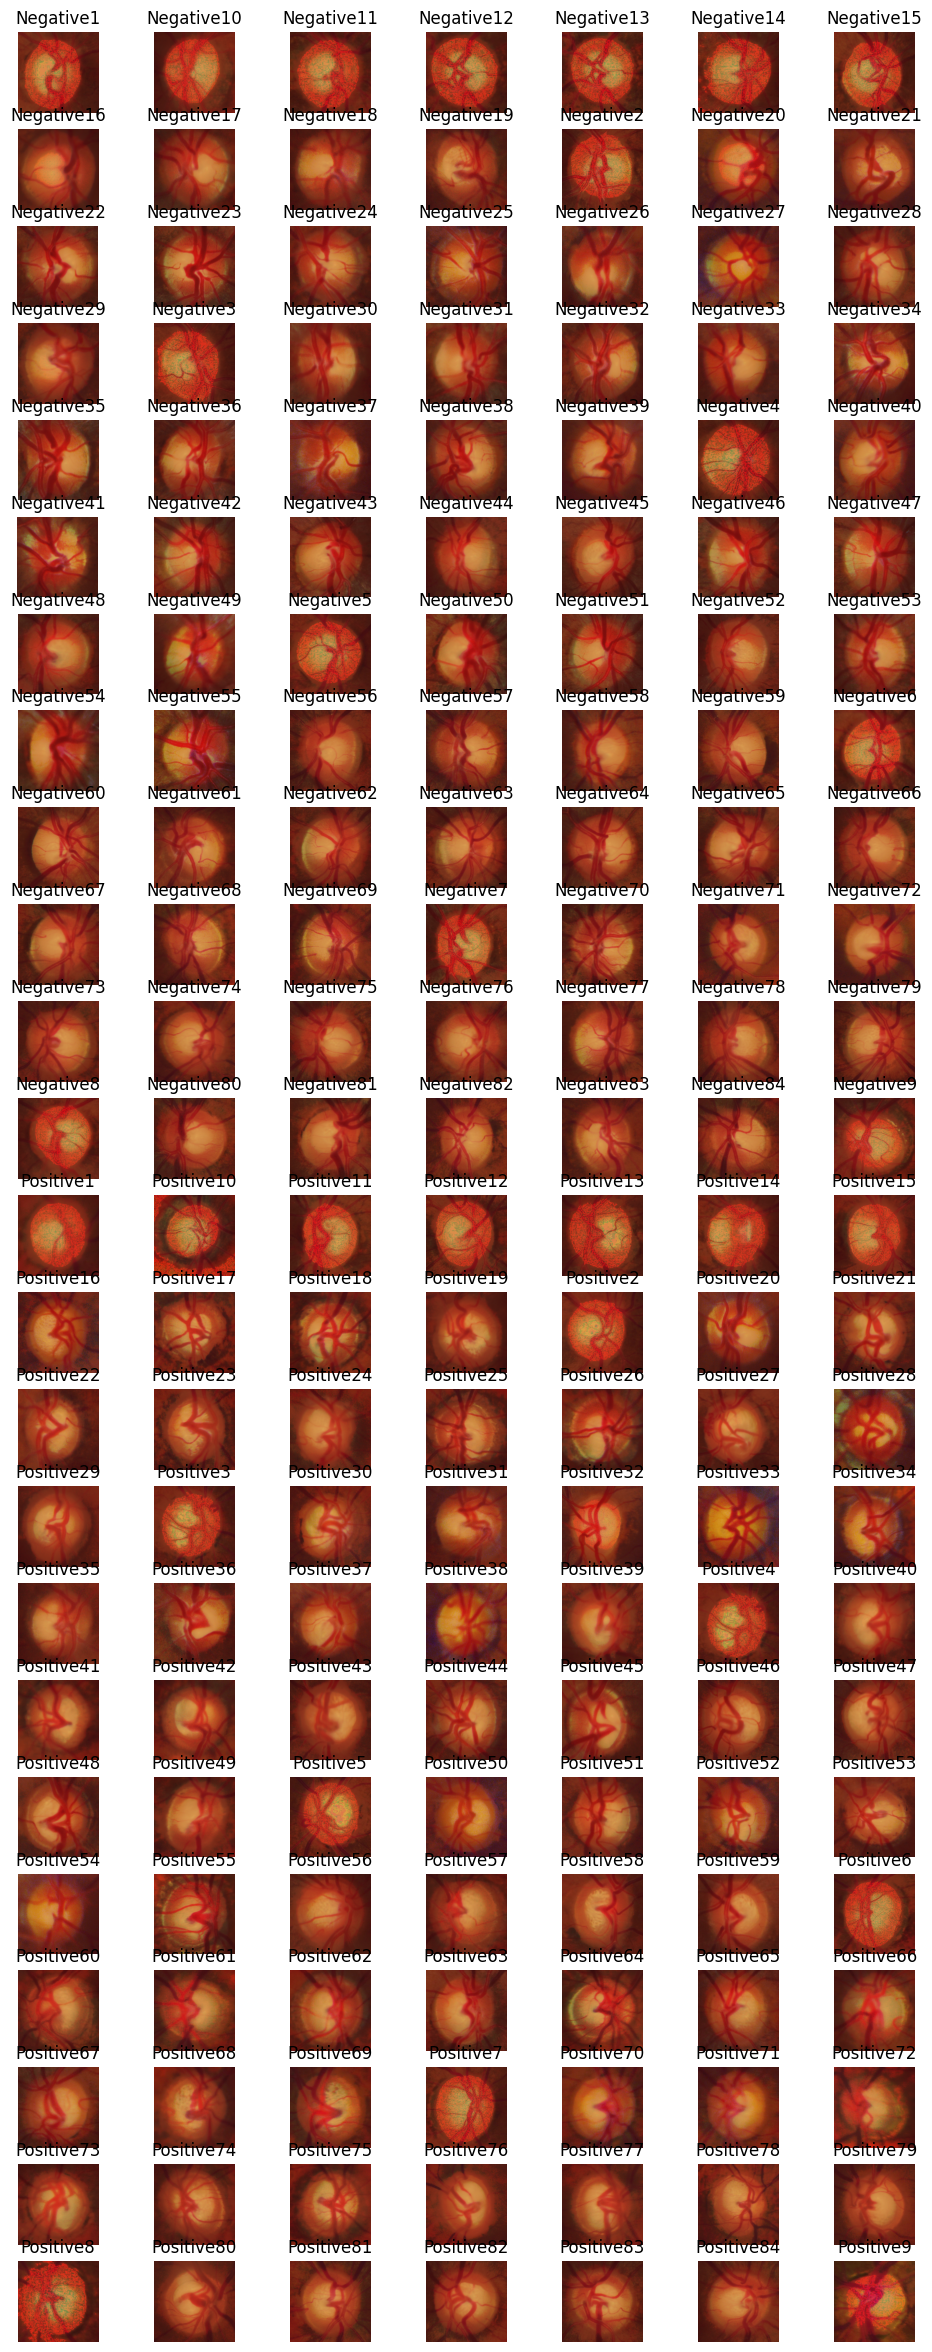

In [9]:
display_all(images_matched, (24,7), (12,30))

## OC Segmentation

In [10]:
def get_circle(contours):
    conts = np.array([contour.shape[0] for contour in contours])
    cont_idx = np.argmax(conts)
    (x,y), radius = cv2.minEnclosingCircle(contours[cont_idx])
    return (x,y), radius

def select_boundaries(bnrs):
    cont, hcy = cv2.findContours(bnrs, 
                                     cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    (x,y),radius = get_circle(cont)
    center = (int(x),int(y))
    radius = int(radius)
    return (center, radius)

def extract_oc(imgs):
    p = {}
    oc_lines = {}
    ocs = {}
    close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (35,35))
    
    for img in imgs:
        green = imgs[img][:,:,1]
        gaussianblur = cv2.GaussianBlur(green, (7,7), 0)
        gmc = adjust_gamma(gaussianblur, 7)
        ret3, th3 = cv2.threshold(
            gmc,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        binaries = cv2.morphologyEx(th3, cv2.MORPH_CLOSE, close_kernel)
        eroded = cv2.erode(binaries, kernel=np.ones((15,15), np.uint8)) #15, 15
        center_rad = select_boundaries(eroded)
        oc_lines[img] = center_rad
        canvas = np.zeros_like(th3, dtype='uint8')
        ocs[img] = cv2.circle(canvas, center_rad[0], center_rad[1], (255, 255, 255), -1)
    print('success!')
    # display_all(p, (24,7), (10,30), True)
    return oc_lines, ocs

In [11]:
oc_bound_lines, all_oc = extract_oc(images_matched)

success!


In [12]:
imgc = deepcopy(images)
drawn_oc = draw_oc_line(imgc, oc_bound_lines, (0, 0, 255))

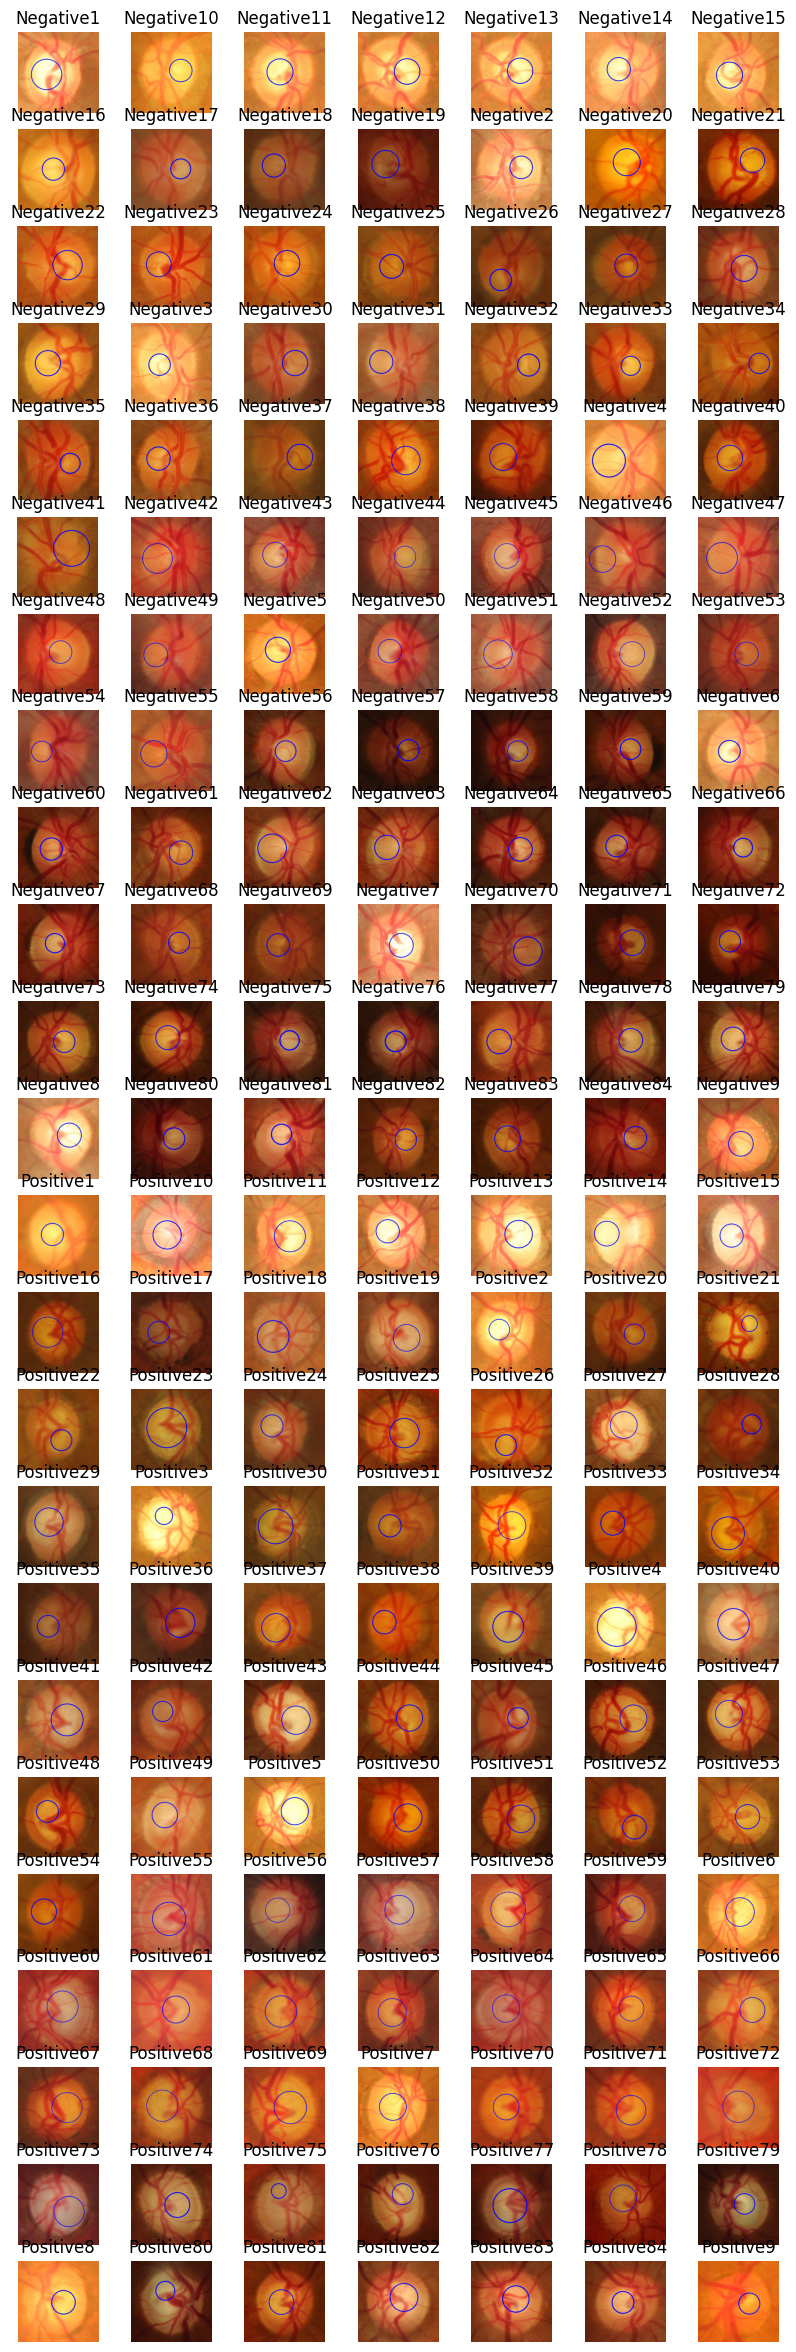

In [13]:
display_all(drawn_oc, (24,7), (10,30))

## Optic Disc Segmentation

In [14]:
def get_which_ellipse(contours):
    conts = np.array([contour.shape[0] for contour in contours])
    cont_idx = np.argmax(conts)
    ellipse = cv2.fitEllipse(contours[cont_idx])
    return ellipse

def set_bleeds(img, trim_border=15):
    '''
    A bleed is a small area around the edge of 
    your artwork that extends beyond the “finished” 
    cut edge of your document.
    '''
    img[:, :trim_border] = 0
    img[:trim_border, :] = 0
    img[-trim_border:, :] = 0
    img[:, -trim_border:] = 0
    
    return img

def extract_od(matched):
    od_line = {}
    ods = {}
    p = {}
    for img in matched:
        # red = matched[img][:,:,0]
        # p[img] = adjust_gamma(red, 2)
        hsv = cv2.cvtColor(matched[img], cv2.COLOR_RGB2HSV)
        v_val = hsv[:,:,2]
        gmc = adjust_gamma(v_val, 3)
        ranged = cv2.inRange(gmc, 35, 255)
        gaussianblur = cv2.GaussianBlur(ranged, (25,25), 0)
        ret, th = cv2.threshold(gaussianblur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        bleed = set_bleeds(th, 20) # 55, 30
        binaries = cv2.erode(bleed, (5,5))
        cont, hcy = cv2.findContours(binaries, 
                                     cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        ellipse = get_which_ellipse(cont)
        od = np.zeros_like(th, dtype='uint8')
        od = cv2.ellipse(od, ellipse, (255, 255, 255), -1)
        ods[img] = od
        od_line[img] = ellipse
    # display_all(p, (24,7), (10,30), True)
    
    print('done!')
    return od_line, ods

In [15]:
od_lines, all_od = extract_od(images_matched)

done!


In [16]:
d_oc = deepcopy(drawn_oc)
full_drawn = draw_od_line(d_oc, od_lines, (0, 255, 0))

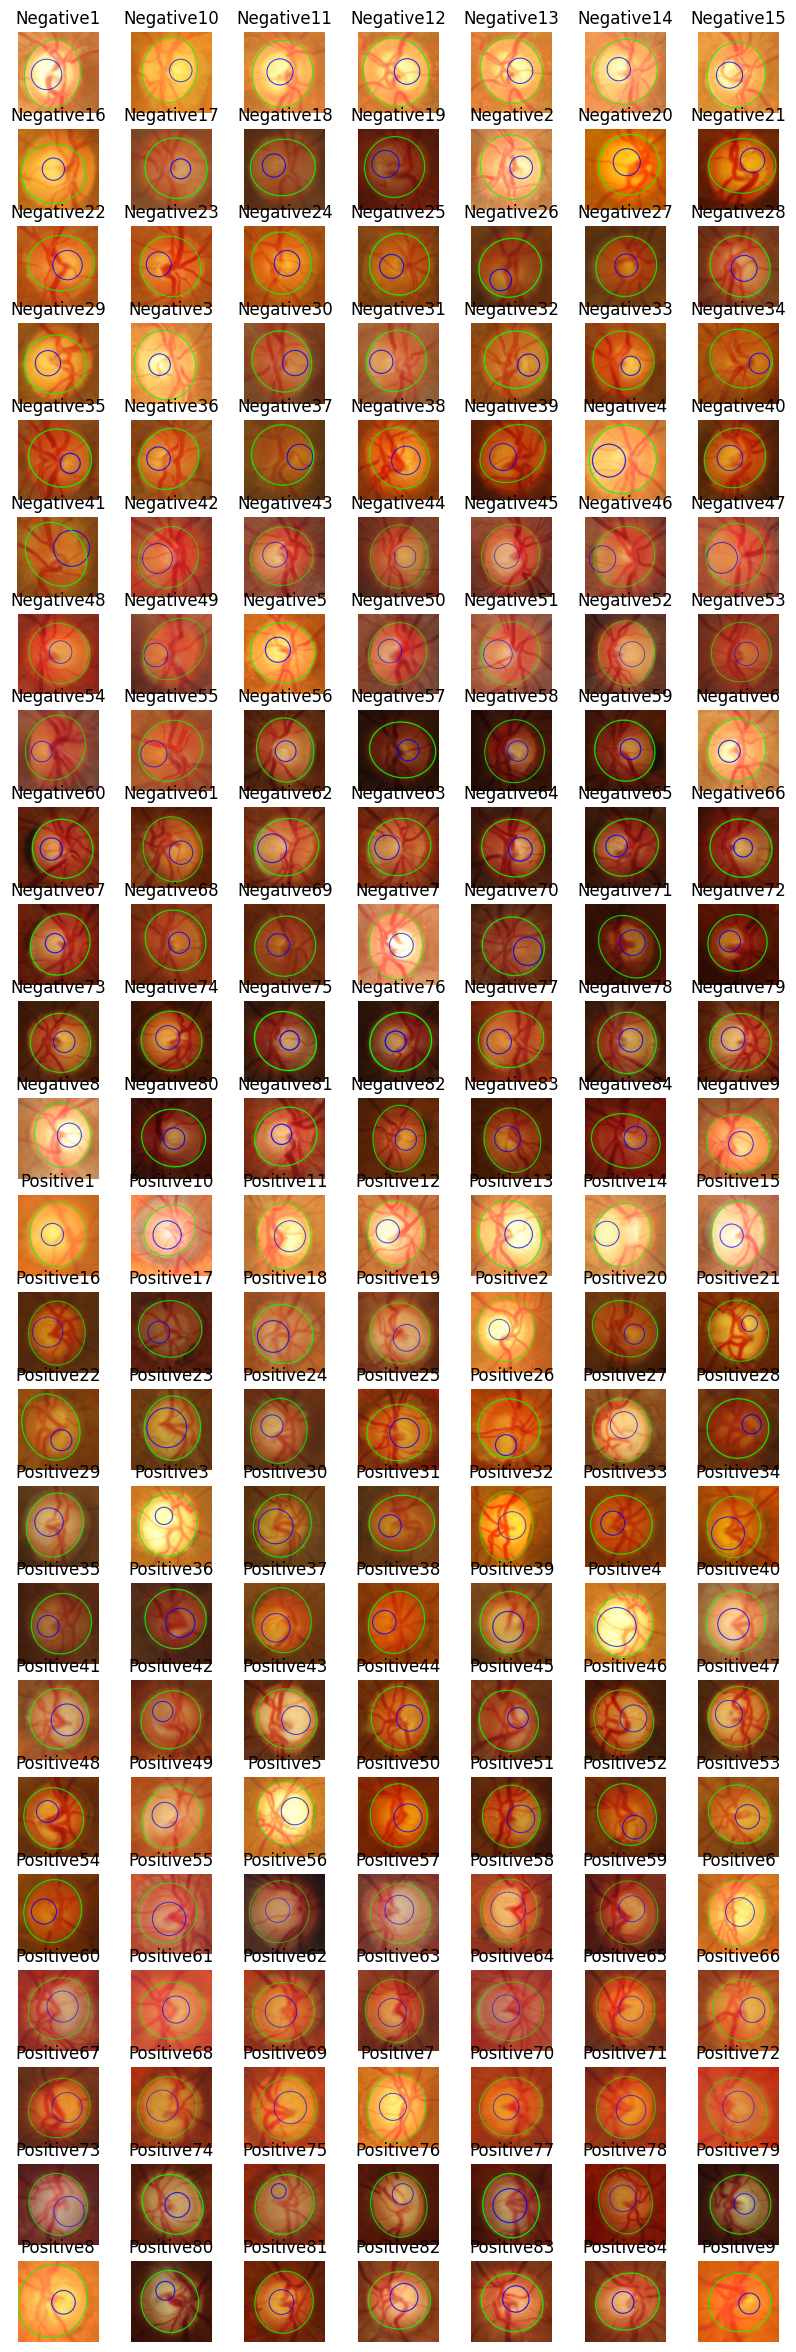

In [17]:
display_all(full_drawn, (24,7), (10,30))

## Feature Extraction

In [18]:
import re

### RDR

In [19]:
def get_rdr(od, oc, dw):
    nrr = cv2.subtract(od, oc)
    ret, th = cv2.threshold(nrr, 128, 255, cv2.THRESH_BINARY)
    conts, _ = cv2.findContours(th, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    RDR = 0
    # cek jika OD dan OC terdeteksi
    if len(conts) != 2:
        RDR = 0.19
        return RDR
    else:
        # ambil contours
        outer = [cv2.approxPolyDP(conts[0], 0.1, True)]
        inner = [cv2.approxPolyDP(conts[1], 0.1, True)]
        # visualisasi
        h, w = nrr.shape[:2]
        # Squeeze contours for further processing
        outer = np.vstack(outer).squeeze()
        inner = np.vstack(inner).squeeze()
        # Calculate centroid of inner contour
        M = cv2.moments(inner)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        # Calculate maximum needed radius for later line intersections
        r_max = np.min([cx, w - cx, cy, h - cy])

        # Set up angles (in degrees)
        angles = np.arange(0, 360, 4)

        # Initialize distances
        dists = np.zeros_like(angles)

        # Prepare calculating the intersections using Shapely
        poly_outer = shapgeo.asLineString(outer)
        poly_inner = shapgeo.asLineString(inner)
        
        for i, angle in enumerate(angles):
            # Convert angle from degrees to radians
            angle = angle / 180 * np.pi

            # Calculate end points of line from centroid in angle's direction
            x = np.cos(angle) * r_max + cx
            y = np.sin(angle) * r_max + cy
            points = [(cx, cy), (x, y)]

            # Calculate intersections using Shapely
            poly_line = shapgeo.LineString(points)
            insec_outer = np.array(poly_outer.intersection(poly_line))
            insec_inner = np.array(poly_inner.intersection(poly_line))

            # Calculate distance between intersections using L2 norm
            try:
                dists[i] = np.linalg.norm(insec_outer - insec_inner)
            except ValueError:
                continue

        # plt.imshow(vis)
        res = np.vstack([angles, dists]).T
        min_dist = min(dists[dists!=0])
        return min_dist/dw
    return 0

### NRR Quadrants

In [20]:
def generate_masks(img_shapes):
    canvas = np.zeros(img_shapes, np.uint8)
    masks = [0,0,0,0]
    triangle_pts = np.array([
        [0, img_shapes[1]],
        [int(img_shapes[1]/2), int(img_shapes[0]/2)],
        [img_shapes[1], img_shapes[1]]
    ])
    masks[0] = cv2.fillPoly(canvas, [triangle_pts],(255, 255, 255))
    angle = 90
    for i in range(1, 4):
        rotation_m = cv2.getRotationMatrix2D((int(masks[0].shape[1]/2), int(masks[0].shape[1])/2), angle, 1.0)
        rotated = cv2.warpAffine(masks[0], rotation_m, (masks[0].shape[1], masks[0].shape[0]))
        masks[i] = rotated
        angle+=90
    return masks

In [21]:
def nrr_quadrant(od, oc):
    masks = generate_masks(od.shape) #  I, N, S, T
    neuroretinal = cv2.subtract(od, oc)
    quadrant_width = [0, 0, 0, 0]
    for i in range(len(masks)):
        masked = cv2.bitwise_and(neuroretinal, masks[i], masks[i])
        ret,binary = cv2.threshold(masked, 127, 255, cv2.THRESH_BINARY)
        contours,hierarchy = cv2.findContours(binary,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        x,y,w,h = cv2.boundingRect(contours[0])
        if i%2 == 0:
            quadrant_width[i] = h
        else:
            quadrant_width[i] = w
    return quadrant_width

### CDR, VCDR

In [22]:
def get_cdr(optics):
    optic_width = [] # order: disc width, cup width
    optic_height = [] # order: disc height, cup height
    for optic in optics:
        cnt, _ = cv2.findContours(optic, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        x,y,w,h = cv2.boundingRect(cnt[0])
        optic_width.append(w)
        optic_height.append(h)
    # print(f'width: {optic_width}\nheight: {optic_height}')
    return optic_width[1]/optic_width[0], optic_height[1]/optic_height[0], optic_width[0]

### Main features extraction

In [23]:
def extract_features(ods, ocs):
    print('Extracting features...')
    features = []
    for od, oc in zip(ods, ocs):
        print(f'Images: {od}')
        identified_label = ' '.join(re.findall('[a-zA-Z]+', od))
        if identified_label.lower() == 'negative':
            label = 0
        else:
            label = 1
        cdr, vcdr, disc_width = get_cdr((ods[od], ocs[oc]))
        quadrant_width = nrr_quadrant(ods[od], ocs[oc])
        I, N, S, T = quadrant_width
        rdr = get_rdr(ods[od], ocs[oc], disc_width)
        features.append([od, cdr, vcdr, rdr, I, S, N, T, label])
    print('Done!')
        
        
    return features

In [24]:
features = extract_features(all_od, all_oc)

Extracting features...
Images: Negative1


/var/folders/zp/4lwldrsx6hqd2pm6w4s0wvg40000gn/T/ipykernel_8424/2841862877.py:14: ShapelyDeprecationWarning: The proxy geometries (through the 'asShape()', 'asLineString()' or 'LineStringAdapter()' constructors) are deprecated and will be removed in Shapely 2.0. Use the 'shape()' function or the standard 'LineString()' constructor instead.
  rdr = get_rdr(ods[od], ocs[oc], disc_width)
/var/folders/zp/4lwldrsx6hqd2pm6w4s0wvg40000gn/T/ipykernel_8424/2841862877.py:14: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  rdr = get_rdr(ods[od], ocs[oc], disc_width)


Images: Negative10
Images: Negative11
Images: Negative12
Images: Negative13
Images: Negative14
Images: Negative15
Images: Negative16
Images: Negative17
Images: Negative18
Images: Negative19
Images: Negative2
Images: Negative20
Images: Negative21
Images: Negative22
Images: Negative23
Images: Negative24
Images: Negative25
Images: Negative26
Images: Negative27
Images: Negative28
Images: Negative29
Images: Negative3
Images: Negative30
Images: Negative31
Images: Negative32
Images: Negative33
Images: Negative34
Images: Negative35
Images: Negative36
Images: Negative37
Images: Negative38
Images: Negative39
Images: Negative4
Images: Negative40
Images: Negative41
Images: Negative42
Images: Negative43
Images: Negative44
Images: Negative45
Images: Negative46
Images: Negative47
Images: Negative48
Images: Negative49
Images: Negative5
Images: Negative50
Images: Negative51
Images: Negative52
Images: Negative53
Images: Negative54
Images: Negative55
Images: Negative56
Images: Negative57
Images: Negative

## Export to CSV

In [25]:
import pandas as pd

In [26]:
dataframe = pd.DataFrame(data=features, 
                         columns=['ImagesName', 'CDR', 'VCDR', 'RDR', 'I', 'S', 'N', 'T', 'Labels'])

In [27]:
dataframe

ImagesName       CDR      VCDR       RDR    I    S    N    T  Labels
0     Negative1  0.543767  0.442765  0.116711  220  205  131  140       0
1    Negative10  0.410188  0.344595  0.088472  193  226  112  188       0
2    Negative11  0.431755  0.389447  0.231198  169  151  130  128       0
3    Negative12  0.388740  0.375648  0.131367  171  173  109  180       0
4    Negative13  0.408971  0.388471  0.147757  169  188  123  173       0
..          ...       ...       ...       ...  ...  ...  ...  ...     ...
163  Positive81  0.424157  0.399471  0.235955  149  144  133  122       1
164  Positive82  0.447977  0.487421  0.167630  125  121  126  141       1
165  Positive83  0.426710  0.454861  0.166124  120  101  110  122       1
166  Positive84  0.345794  0.385417  0.233645  110  114  140  108       1
167   Positive9  0.337176  0.362229  0.175793  167  157    3  166       1

[168 rows x 9 columns]

In [28]:
dataframe.to_csv('../exportedDataframe/a_features.csv', 
                 index=False, encoding='utf-8')